# **TP 4: Improve the Metropolis-Hastings algorithm**

In [174]:
from logging import warning
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.stats import invgamma
warnings.filterwarnings('ignore')

## **Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler (9pt)**

### **1.A - Metropolis-Hastings within a Random Scan Gibbs sampler**

#### **Question 1**

This algorithm is called a Random Scan Gibbs sampler because of the form of the transition kernel $P = \frac{1}{2}(P_1 + P_2)$. At each iteration, the algorithm randomly picks the index of the coordinate to update with a uniform distribution, while keeping the other coordinate fixed. In a classical Gibbs sampler, each coordinate is updated sequentially.

Once a coordinate is selected, the algorithm proposes a new value using a symmetric random walk and then accepts or rejects it using the Metropolis-Hastings acceptance probability, rather than sampling directly from the exact conditional distribution.

#### **Question 2**

In [175]:
def pi(z, a):
  '''
  Compute the target distribution pi with parameter a at z.
  '''
  x, y = z
  return np.exp(-(x/a)**2-y**2-(0.25)*(((x/a)**2-y**2)**2))

In [176]:
def MH_P1(current_z, target_distrib, sigma_1):
  """
  Inputs

  current_z : current position of the chain
  target_distrib : distribution we which to sample from
  sigma_1 : std of the proposal
  Returns

  new_z : new vector z resulted from one iteration of MH for the first coordinate
  """
  x, y = current_z
  new_x = x + np.random.normal(0, sigma_1)
  new_z = np.array([new_x, y])
  acceptation_ratio = min(1, target_distrib(new_z)/target_distrib(current_z))
  if np.random.rand() < acceptation_ratio:
    return new_z, True
  else:
    return current_z, False

def MH_P2(current_z, target_distrib, sigma_2):
  """
  Inputs

  current_z : current position of the chain
  target_distrib : distribution we which to sample from
  sigma_2 : std of the proposal
  Returns

  new_z : new vector z resulted from one iteration of MH for the second coordinate
  """
  x, y = current_z
  new_y = y + np.random.normal(0, sigma_2)
  new_z = np.array([x, new_y])
  acceptation_ratio = min(1, target_distrib(new_z)/target_distrib(current_z))
  if np.random.rand() < acceptation_ratio:
    return new_z, True
  else:
    return current_z, False


def MH_P(current_z, target_distrib, sigma_list):
  """
  Computes one iteration of Random Scan Gibbs MH.

  Inputs

  current_z : current position of the chain
  target_distrib : distribution we which to sample from
  sigma : list containing sigma_1 and sigma_2, the proposals standard deviations
  Returns

  new_z : new vector z resulted from one iteration of Random Scan Gibbs MH
  """
  sigma_1, sigma_2 = sigma_list
  # Random scan
  if np.random.rand() < 0.5: #sample from first coordinate
    new_z, accept = MH_P1(current_z, target_distrib, sigma_1)
    coordinate = 1 #coordinate 1 has been updated
  else: #sample from second coordinate
    new_z, accept = MH_P2(current_z, target_distrib, sigma_2)
    coordinate = 2 #coordinate 2 has been updated
  return new_z, accept, coordinate


#### **Question 3**

In [177]:
def MHwRSG(z_init, target_distrib, sigma_list, n_iter):
  """
  Computes n_iter iterations of Random Scan Gibbs MH algorithm.

  Inputs

  current_z : current position of the chain
  target_distrib : distribution we which to sample from
  sigma : list containing sigma_1 and sigma_2, the proposals standard deviations
  n_iter : number of iterations of the algorithm
  Returns

  z_list : list containing the chain resulting from the algorithm
  acc_x : total acceptance rate along the first coordinate
  acc_y : total acceptance rate along the second coordinate
  acc_x_list : list containing the acceptance rate along the first coordinate each 50 batches
  acc_y_list : list containing the acceptance rate along the second coordinate each 50 batches
  """
  z_list = np.zeros((n_iter, 2))
  current_z = z_init
  acc_x = 0
  acc_y = 0
  acc_batch_x = 0
  acc_batch_y = 0
  acc_x_list = []
  acc_y_list = []
  for i in range(n_iter):
    current_z, accept, coordinate = MH_P(current_z, target_distrib, sigma_list)
    z_list[i] = current_z
    if accept and coordinate == 1:
      acc_x += 1
      acc_batch_x +=1
    elif accept and coordinate == 2:
      acc_y += 1
      acc_batch_y +=1

    # We save the acceptance rate every 50 batches
    if i % 50 == 0:
      acc_x_list.append(acc_batch_x*100/50)
      acc_y_list.append(acc_batch_y*100/50)
      acc_batch_x, acc_batch_y = 0, 0

  acc_x *=100/n_iter
  acc_y *=100/n_iter

  return z_list, acc_x, acc_y, acc_x_list, acc_y_list

Metropolis-Hasting within Random-Scan Gibbs sampling of 10000 samples ...


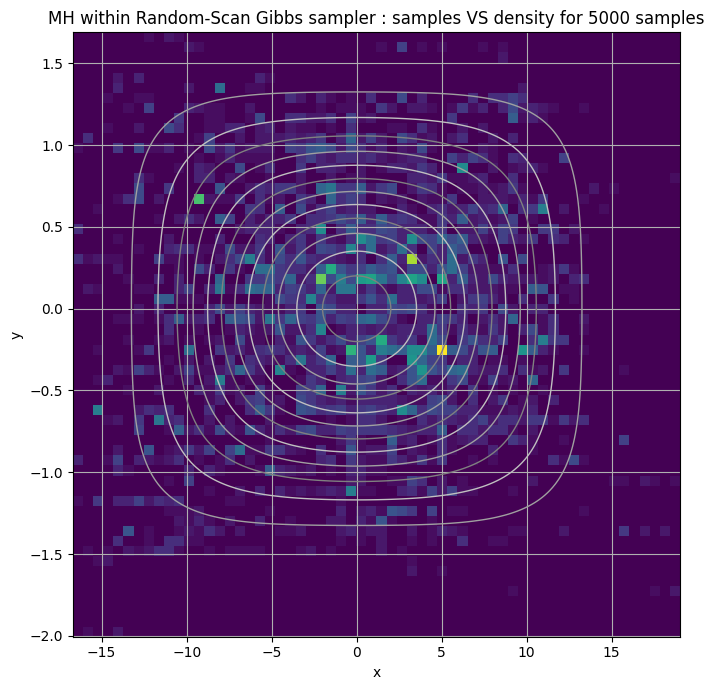

Acceptance rate for x: 43.22%
Acceptance rate for y: 12.41%


In [178]:
np.random.seed(24)

# Parameters of the sampling
a = 10
target_distrib = lambda z : pi(z, a)

sigma_1 = 3
sigma_2 = 3
sigma_list = np.array([sigma_1, sigma_2])

n_iter = 10000
n_burn_in = int(0.5 * n_iter)
z_init = np.random.randn(2,) #random initialization

print(f"Metropolis-Hasting within Random-Scan Gibbs sampling of {n_iter} samples ...")
samples, acc_x, acc_y, acc_x_list, acc_y_list = MHwRSG(z_init, target_distrib, sigma_list, n_iter)

# Keep only post burn-in samples
samples = samples[n_burn_in:]

# Grid for the true density
x = np.linspace(-15, 15, 200)
y = np.linspace(-2.5, 2.5, 200)
X, Y = np.meshgrid(x, y)

Z = target_distrib([X, Y])

plt.figure(figsize=(7, 7))

# 2D histogram of the samples
plt.hist2d(samples[:, 0], samples[:, 1],
           bins=60, density=True)


# Contours of the true target density
plt.contour(X, Y, Z, levels=15, linewidths=1, colors = ['#808080', '#A0A0A0', '#C0C0C0'])

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"MH within Random-Scan Gibbs sampler : samples VS density for {n_burn_in} samples")
plt.grid()
plt.tight_layout()
plt.show()

print(f"Acceptance rate for x: {acc_x}%")
print(f"Acceptance rate for y: {acc_y}%")

**Acceptance rate for both x and y**

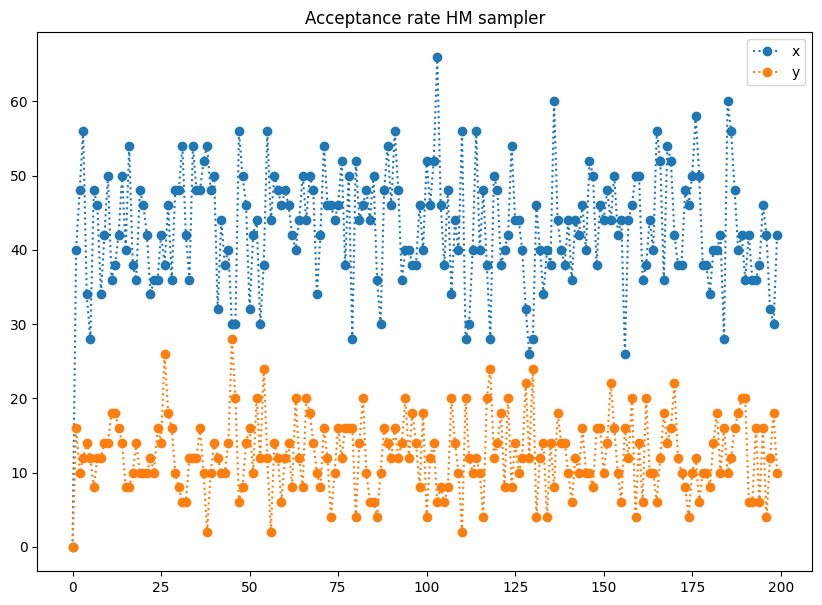

In [179]:
plt.figure(figsize=(10,7))
plt.plot(acc_x_list , 'o:', label = 'x')
plt.plot(acc_y_list ,'o:', label = 'y')
plt.legend()
plt.title('Acceptance rate HM sampler')
plt.show()

**Auto-correlation plots**

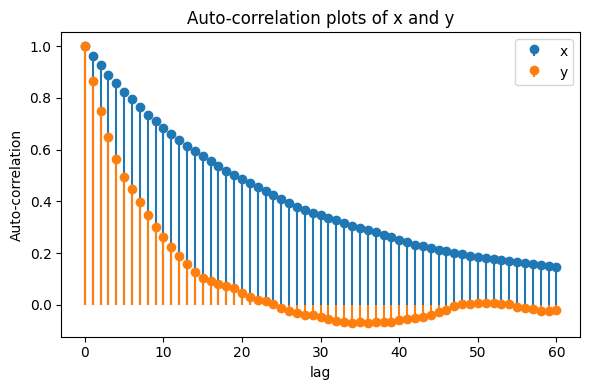

In [180]:
max_lag = 60
lags = np.arange(max_lag + 1)

acf_x = acf(samples[:, 0], nlags=max_lag)
acf_y = acf(samples[:, 1], nlags=max_lag)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.stem(lags, acf_x, linefmt='C0-', markerfmt='C0o', basefmt=' ', label='x')
ax.stem(lags, acf_y, linefmt='C1-', markerfmt='C1o', basefmt=' ', label='y')

ax.set_title("Auto-correlation plots of x and y")
ax.set_xlabel("lag")
ax.set_ylabel("Auto-correlation")
ax.legend()
plt.tight_layout()
plt.show()

**Performance of the algorithm**

- For the $x$ coordinate, the acceptance rate is much higher than the usual MH target (about $23.4\%$). This means the proposal steps are too small: almost all moves are accepted, but the chain moves slowly and the ACF for $x$ decays very slowly, showing strong correlation and poor mixing.

- For the $y$ coordinate, the acceptance rate is closer to the target. The ACF for $y$ drops much faster, which indicates better mixing and a larger effective sample size in that direction.

#### **Question 4**

The first and most intuitive idea to improve the performance of the algorithm is to increase $\sigma_1$ so that the acceptance rate for $x$ decreases, and conversely decrease $σ_2$ to increase the acceptance rate for $y$ and get closer to $23.4\%$. Even better, we could design an adaptive method that automatically tunes the hyperparameters $\sigma_1$ and $\sigma_2$ in order to obtain better mixing, which will be done in the next part of the tutorial.


Metropolis-Hasting within Random-Scan Gibbs sampling of 10000 samples ...


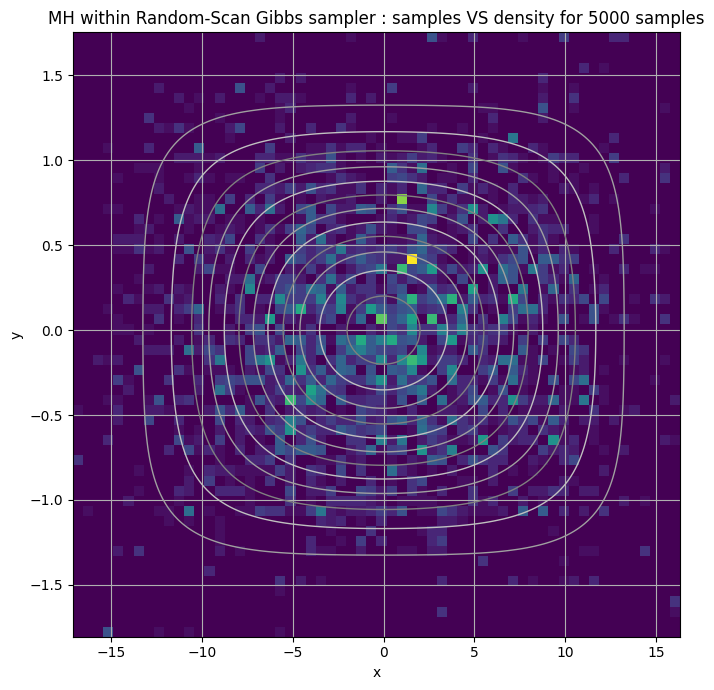

Acceptance rate for x: 24.56%
Acceptance rate for y: 21.16%


In [181]:
np.random.seed(24)

sigma_1 = 14 # increase sigma_1
sigma_2 = 1.6 # decrease sigma_2
sigma_list = np.array([sigma_1, sigma_2])

print(f"Metropolis-Hasting within Random-Scan Gibbs sampling of {n_iter} samples ...")
samples, acc_x, acc_y, acc_x_list, acc_y_list = MHwRSG(z_init, target_distrib, sigma_list, n_iter)

# Keep only post burn-in samples
samples = samples[n_burn_in:]

# Grid for the true density
x = np.linspace(-15, 15, 200)
y = np.linspace(-2.5, 2.5, 200)
X, Y = np.meshgrid(x, y)

Z = target_distrib([X, Y]).reshape(X.shape)


plt.figure(figsize=(7, 7))

# Samples histogram
plt.hist2d(samples[:, 0], samples[:, 1], bins=60, density=True)

# Contour of the target distribution
plt.contour(X, Y, Z, levels=15, linewidths=1, colors = ['#808080', '#A0A0A0', '#C0C0C0'])
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"MH within Random-Scan Gibbs sampler : samples VS density for {n_burn_in} samples")
plt.grid()
plt.tight_layout()
plt.show()

print(f"Acceptance rate for x: {acc_x:.2f}%")
print(f"Acceptance rate for y: {acc_y:.2f}%")

**Acceptance rates for both $x$ and $y$ axis**

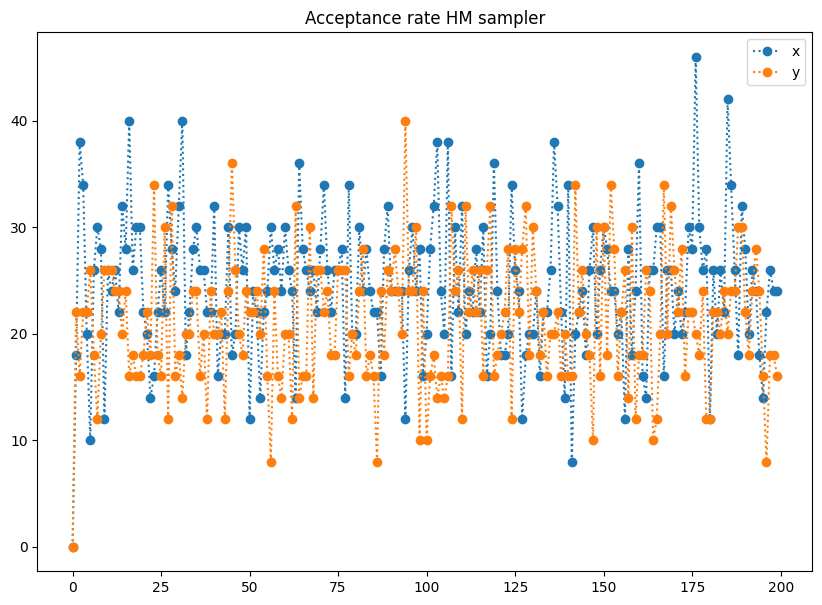

In [182]:
plt.figure(figsize=(10,7))
plt.plot(acc_x_list , 'o:', label = 'x')
plt.plot(acc_y_list ,'o:', label = 'y')
plt.legend()
plt.title('Acceptance rate HM sampler')
plt.show()

**Auto-correlation plots**

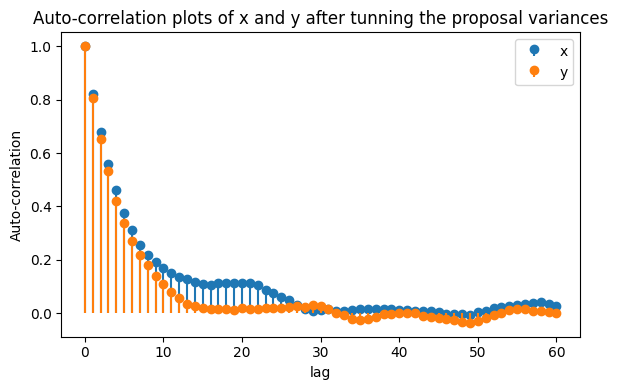

In [183]:
max_lag = 60
lags = np.arange(max_lag + 1)

acf_x = acf(samples[:, 0], nlags=max_lag)
acf_y = acf(samples[:, 1], nlags=max_lag)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.stem(lags, acf_x, linefmt='C0-', markerfmt='C0o', basefmt=' ', label='x')
ax.stem(lags, acf_y, linefmt='C1-', markerfmt='C1o', basefmt=' ', label='y')

ax.set_title("Auto-correlation plots of x and y after tunning the proposal variances")
ax.set_xlabel("lag")
ax.set_ylabel("Auto-correlation")
ax.legend()
plt.tight_layout()
plt.show()

The tuning of the variances effectively improved the sampling, by increasing the mixing speed as seen on the auto-correlation plots, and by producing samples that better match the target density.

### **1.B  Adaptive Metropolis-Hastings within Gibbs sampler**

#### **Question 1**

First, let's implement the classical Metropolis-Hastings withing Gibbs sampler.

In [184]:
def MHwG(z_init, target_distrib, n_iter, parameters):
  """
  Computes n_iter iterations of MH within Gibbs algorithm.

  Inputs

  z_init : current position of the chain
  target_distrib : distribution we which to sample from
  n_iter : number of iterations of the algorithm
  parameters : dictionnary containing the parameters:
        - prop_cov_list : list containing the proposal standard deviations

  Returns

  samples : list containing the chain resulting from the algorithm
  acceptance_rate : list containing the total acceptance rate along each coordinate
  """
  d = len(z_init)
  samples = np.zeros((n_iter, d))
  acceptance_count = np.zeros(d)

  prop_cov_list = parameters["prop_cov_list"]

  current_z = np.array(z_init, dtype=float)

  for i in range(n_iter):
    for j in range(d):
      sigma_j = prop_cov_list[j]

      proposal = current_z.copy()
      proposal[j] = current_z[j] + np.random.normal(0, sigma_j)

      ratio = target_distrib(proposal) / target_distrib(current_z)
      alpha = min(1.0, ratio)

      if np.random.rand() < alpha:
        current_z = proposal
        acceptance_count[j] += 1

    samples[i] = current_z

  acceptance_rate = 100 * acceptance_count / n_iter
  return samples, acceptance_rate


Now, we implement the adaptative version.

In [185]:
def MHwG_adapt(z_init, target_distrib, n_iter, batch_size=50):
  """
  Computes n_iter iterations of Adaptative MH within Gibbs algorithm.

  Inputs

  z_init : current position of the chain
  target_distrib : distribution we which to sample from
  n_iter : number of iterations of the algorithm

  Returns

  samples : list containing the chain resulting from the algorithm
  acceptance_rate : list containing the total acceptance rate along each coordinate
  sigmas : list containing the tunned standard deviations
  """
  d = len(z_init)
  samples = np.zeros((n_iter, d))
  acceptance_total = np.zeros(d)
  acceptance_block = np.zeros(d)

  l = np.zeros(d)  # log(sigmas), sigmas = exp(l)
  current_z = np.array(z_init, dtype=float)

  for i in range(n_iter):
    for j in range(d):
      sigma_j = np.exp(l[j])

      proposal = current_z.copy()
      proposal[j] = current_z[j] + np.random.normal(0, sigma_j)

      ratio = target_distrib(proposal) / target_distrib(current_z)
      alpha = min(1.0, ratio)

      if np.random.rand() < alpha:
        current_z = proposal
        acceptance_total[j] += 1
        acceptance_block[j] += 1

    samples[i] = current_z

    # Adaptative part : updating l_i every "batch_size" batches
    if (i + 1) % batch_size == 0:
      j = (i + 1) // batch_size
      delta = min(0.05, j**(-0.5))

      acc_rate_block = acceptance_block / batch_size
      for k in range(d):
        if acc_rate_block[k] > 0.234:
          l[k] += delta
        else:
          l[k] -= delta

      acceptance_block[:] = 0  # reset for the next block of "batch_size" batches

  acceptance_rate = 100 * acceptance_total / n_iter
  sigmas = np.exp(l)
  return samples, acceptance_rate, sigmas


Test of both our algorithms on the target $\pi$.

In [186]:
np.random.seed(24)

a = 10
z_init = np.array([0.0, 0.0])
n_iter = 20000

n_burn_in = int(0.5 * n_iter)
sigma_list = np.array([3.0, 3.0]) #initial sigmas before tunning

parameters = {'a': a, 'prop_cov_list': sigma_list}

print(f"Classical MH within Gibbs sampling of {n_iter} samples ...")
samples_na, acc_na = MHwG(z_init, target_distrib, n_iter, parameters)
samples_na = samples_na[n_burn_in:]

print(f"Adaptive MH within Gibbs of {n_iter} samples ...")
samples_ad, acc_ad, sigmas_ad = MHwG_adapt(z_init, target_distrib, n_iter)
samples_ad = samples_ad[n_burn_in:]

print("Non-adaptive acceptance rates (x, y):", acc_na)
print("Adaptive acceptance rates (x, y):   ", acc_ad)
print("Final adaptive sigmas:", sigmas_ad)

Classical MH within Gibbs sampling of 20000 samples ...
Adaptive MH within Gibbs of 20000 samples ...
Non-adaptive acceptance rates (x, y): [86.005 26.015]
Adaptive acceptance rates (x, y):    [31.8  23.88]
Final adaptive sigmas: [33.11545196  3.32011692]


**Plots of contour and 2D histograms for each algorithm**

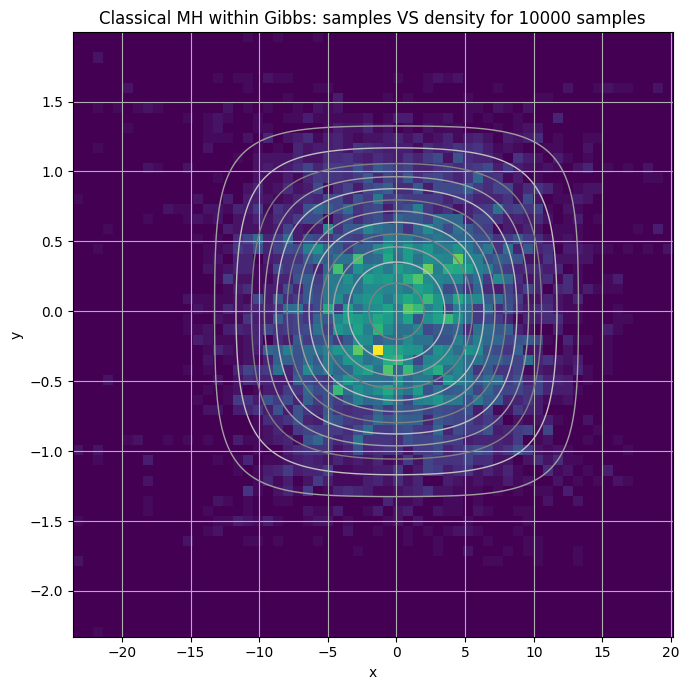

Acceptance rate for x: 86.00%
Acceptance rate for y: 26.02%


In [187]:
# Grid for the true density
x = np.linspace(-15, 15, 200)
y = np.linspace(-2.5, 2.5, 200)
X, Y = np.meshgrid(x, y)

Z = target_distrib([X, Y]).reshape(X.shape)


plt.figure(figsize=(7, 7))

# Samples histogram
plt.hist2d(samples_na[:, 0], samples_na[:, 1], bins=60, density=True)

# Contour of the target distribution
plt.contour(X, Y, Z, levels=15, linewidths=1, colors = ['#808080', '#A0A0A0', '#C0C0C0'])
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Classical MH within Gibbs: samples VS density for {n_burn_in} samples")
plt.grid()
plt.tight_layout()
plt.show()

print(f"Acceptance rate for x: {acc_na[0]:.2f}%")
print(f"Acceptance rate for y: {acc_na[1]:.2f}%")

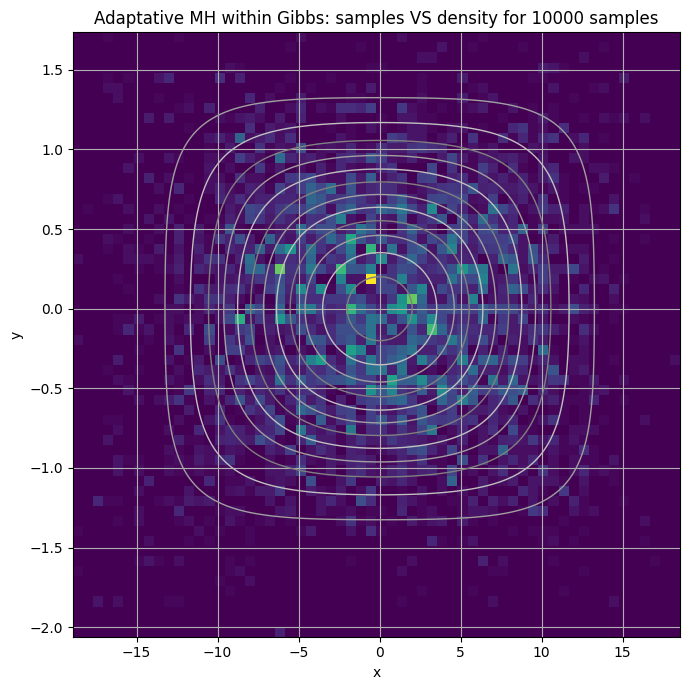

Acceptance rate for x: 31.80%
Acceptance rate for y: 23.88%


In [188]:
# Grid for the true density
x = np.linspace(-15, 15, 200)
y = np.linspace(-2.5, 2.5, 200)
X, Y = np.meshgrid(x, y)

Z = target_distrib([X, Y]).reshape(X.shape)


plt.figure(figsize=(7, 7))

# Samples histogram
plt.hist2d(samples_ad[:, 0], samples_ad[:, 1], bins=60, density=True)

# Contour of the target distribution
plt.contour(X, Y, Z, levels=15, linewidths=1, colors = ['#808080', '#A0A0A0', '#C0C0C0'])
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Adaptative MH within Gibbs: samples VS density for {n_burn_in} samples")
plt.grid()
plt.tight_layout()
plt.show()

print(f"Acceptance rate for x: {acc_ad[0]:.2f}%")
print(f"Acceptance rate for y: {acc_ad[1]:.2f}%")

**Auto-correlation plots**

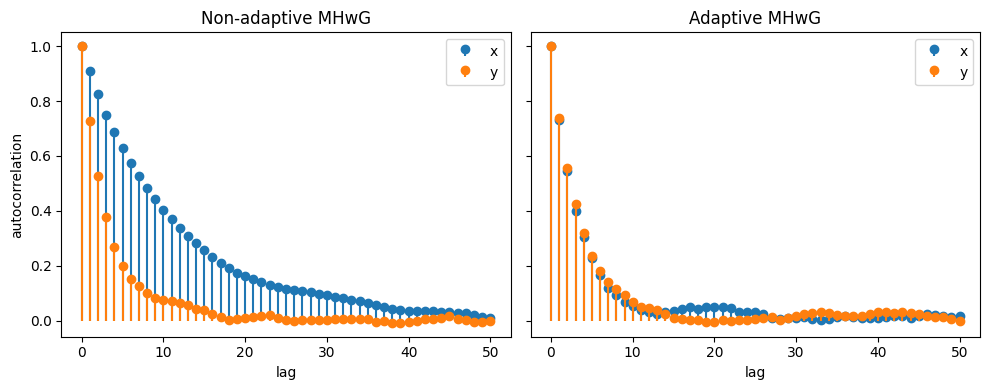

In [189]:
max_lag = 50
lags = np.arange(max_lag + 1)

acf_na_x = acf(samples_na[:, 0], nlags=max_lag)
acf_na_y = acf(samples_na[:, 1], nlags=max_lag)
acf_ad_x = acf(samples_ad[:, 0], nlags=max_lag)
acf_ad_y = acf(samples_ad[:, 1], nlags=max_lag)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax = axes[0]
ax.stem(lags, acf_na_x, linefmt='C0-', markerfmt='C0o', basefmt=' ', label='x')
ax.stem(lags, acf_na_y, linefmt='C1-', markerfmt='C1o', basefmt=' ', label='y')
ax.set_title("Non-adaptive MHwG")
ax.set_xlabel("lag")
ax.set_ylabel("autocorrelation")
ax.legend()

ax = axes[1]
ax.stem(lags, acf_ad_x, linefmt='C0-', markerfmt='C0o', basefmt=' ', label='x')
ax.stem(lags, acf_ad_y, linefmt='C1-', markerfmt='C1o', basefmt=' ', label='y')
ax.set_title("Adaptive MHwG")
ax.set_xlabel("lag")
ax.legend()

plt.tight_layout()
plt.show()

**Comparison of the perfomance of both algorithms**


* In the non adaptive case, the autocorrelation of $x$ decreases slowly, which translates a poor mixing for this coordonate. The $y$ coordinate mixes better, but still shows non negligible correlation for the first lags.

* In the adaptive case, the auto-correlation functions of both $x$ and $y$ drop much faster. This means the tuned proposal variances produce more efficient moves, and the effective sample size is larger in both directions, especially for $x$.


#### **Question 2**


**Introducing the banana-shaped density $f_B$**

In [190]:
def f_B(x, B):
  """
  Computes the value of function f_B with parameter B at point x

  Inputs

  x : vector in R^d
  B : float parameter for the function

  Returns

  Value of f_B at point x
  """
  return np.exp(- 0.5*x[0]**2 - 0.5*(x[1] + B*x[0]**2 - B)**2 -0.5*np.sum(x[2:]**2))

**Sampling from $f_B$ for both algorithms**

In [191]:
np.random.seed(24)

# Parameters of f_B
B = 0.4
d = 5

z_init = np.array([0.0] * d)
n_iter = 20000
n_burn_in = int(0.5 * n_iter)
sigma_list = np.array([1.0] * d)

parameters = {'a': a, 'prop_cov_list': sigma_list}

banana_shaped = lambda z: f_B(z, B)

print(f"Classical MH within Gibbs sampling of {n_iter} samples ...")
samples_na, acc_na = MHwG(z_init, banana_shaped, n_iter, parameters)
samples_na = samples_na[n_burn_in:]

print(f"Adaptive MH within Gibbs of {n_iter} samples ...")
samples_ad, acc_ad, sigmas_ad = MHwG_adapt(z_init, banana_shaped, n_iter)
samples_ad = samples_ad[n_burn_in:]

print("Non-adaptive acceptance rates :", acc_na)
print("Adaptive acceptance rates :   ", acc_ad)
print("Final adaptive sigmas:", sigmas_ad)

Classical MH within Gibbs sampling of 20000 samples ...
Adaptive MH within Gibbs of 20000 samples ...
Non-adaptive acceptance rates : [68.91  70.475 70.775 70.3   70.06 ]
Adaptive acceptance rates :    [25.245 25.11  25.1   25.015 24.835]
Final adaptive sigmas: [4.95303242 5.47394739 4.95303242 4.95303242 5.47394739]


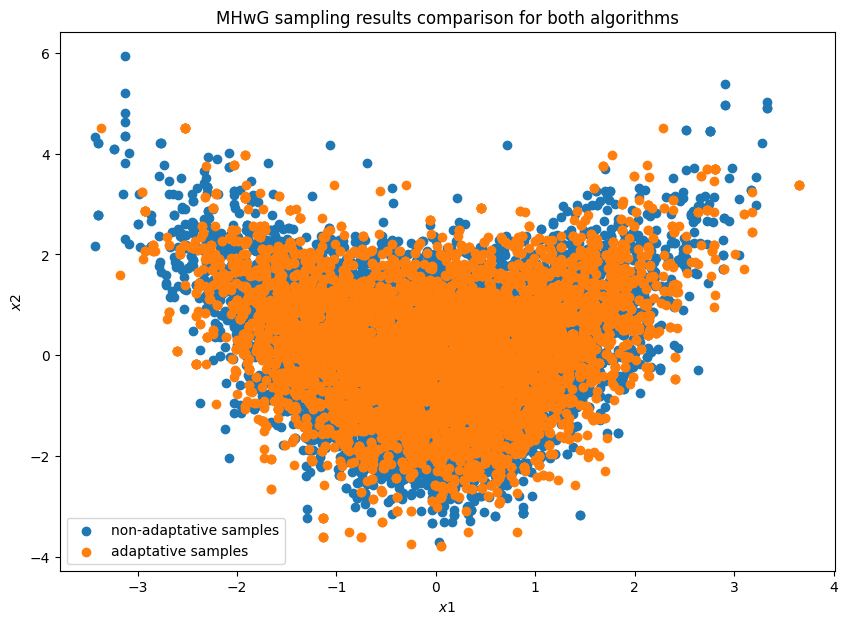

In [192]:
plt.figure(figsize=(10,7))
plt.scatter(samples_na[:,0],-samples_na[:,1], label ='non-adaptative samples')
plt.scatter(samples_ad[:,0], -samples_ad[:,1], label="adaptative samples")
plt.title('MHwG sampling results comparison for both algorithms')
plt.legend()
plt.xlabel('$x1$')
plt.ylabel('$x2$')
plt.show()

**Auto-correlation plots**

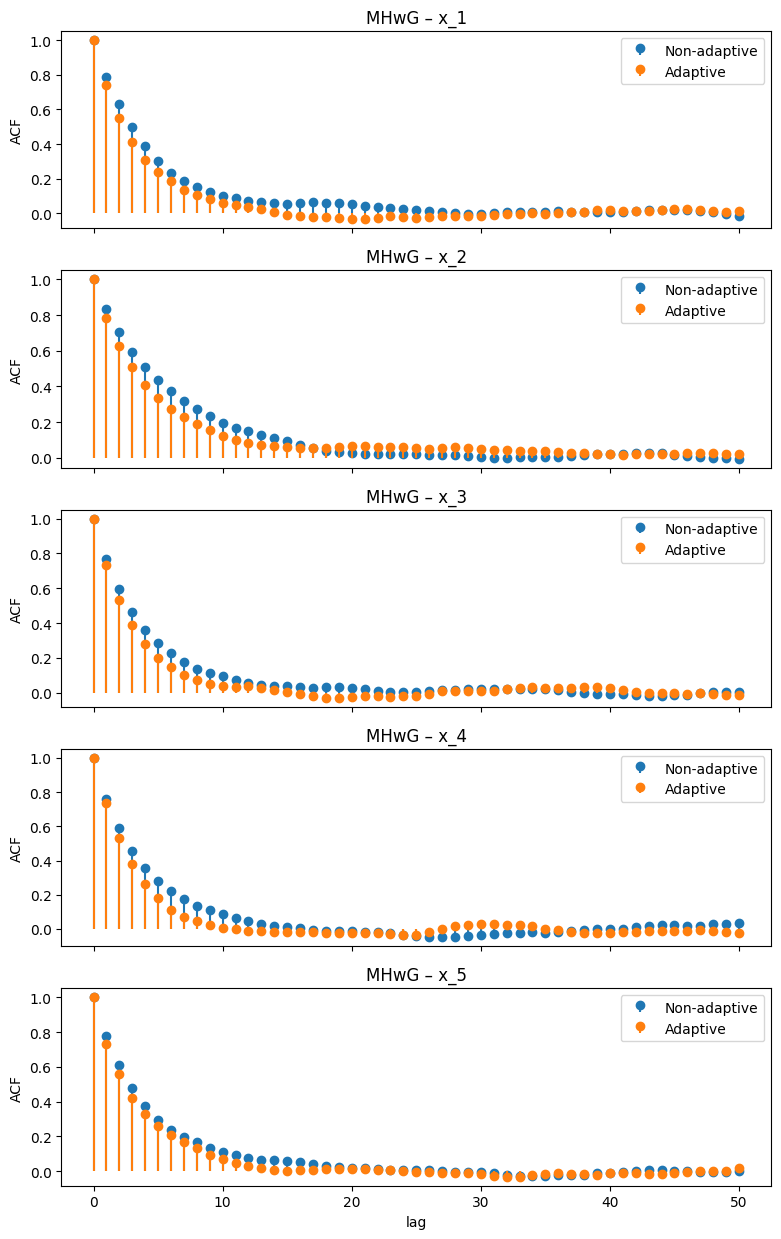

In [193]:
max_lag = 50
lags = np.arange(max_lag + 1)

fig, axes = plt.subplots(d, 1, figsize=(8, 2.5 * d), sharex=True)

for i in range(d):
  ax = axes[i] if d > 1 else axes

  acf_na = acf(samples_na[:, i], nlags=max_lag)
  acf_ad = acf(samples_ad[:, i], nlags=max_lag)

  ax.stem(lags, acf_na,
          linefmt='C0-', markerfmt='C0o', basefmt=' ', label='Non-adaptive')
  ax.stem(lags, acf_ad,
          linefmt='C1-', markerfmt='C1o', basefmt=' ', label='Adaptive')

  ax.set_title(f"MHwG – x_{i+1}")
  ax.set_ylabel("ACF")
  ax.legend()

axes[-1].set_xlabel("lag")

plt.tight_layout()
plt.show()


Here again, the adaptative algorithm provides a better sampling for the target distribution $f_B$, and thus shows the capability to generalise to more complex target distributions.

## **Exercise 2: Sampling from multimodal distributions (8pt)**


### **2.A - A toy example**


#### **Question 1**

In [194]:
def mixture_of_gaussians(x, weights_list, mean_list, std_list):
  """
  Computes the value of a Gaussian mixture density at point x.

  Inputs

  x : point at which to evaluate the density
  weights_list : list or array of mixture weights w_i
  mean_list : list or array of component means mu_i
  std_list : list or array of component standard deviations sigma_i

  Returns

  pi_x : value of pi(x)
  """
  x = np.asarray(x)
  weights = np.asarray(weights_list)
  means = np.asarray(mean_list)
  stds = np.asarray(std_list)

  d = x.shape[-1]

  diffs = x - means
  sq_norm = np.sum(diffs**2, axis=1)

  var = stds**2
  norm_const = 1.0 / ((2 * np.pi * var)**(d / 2))

  components = weights * norm_const * np.exp(-0.5 * sq_norm / var)
  return np.sum(components)


def log_mixture_of_gaussians(x, weights_list, mean_list, std_list):
  """
  Computes the log-density log pi(x) of a Gaussian mixture at point x.

  Inputs

  x : point at which to evaluate the density
  weights_list : list or array of mixture weights w_i
  mean_list : list or array of component means mu_i
  std_list : list or array of component standard deviations sigma_i

  Returns

  log_pi_x : value of log pi(x)
  """
  x = np.asarray(x)
  weights = np.asarray(weights_list)
  means = np.asarray(mean_list)
  stds = np.asarray(std_list)

  d = x.shape[-1]

  diffs = x - means
  sq_norm = np.sum(diffs**2, axis=1)
  var = stds**2

  log_terms = (np.log(weights)- d / 2 * np.log(2 * np.pi * var)- 0.5 * sq_norm / var)

  m = np.max(log_terms)
  log_pi = m + np.log(np.sum(np.exp(log_terms - m)))
  return log_pi


For a Gaussian mixture, the log-density is calculated as:
$$\log \pi(x) = \log \left( \sum_{i=1}^K \exp(\text{log\_term}_i) \right)$$

A naive implementation using `np.log(np.sum(np.exp(...)))` is numerically unstable as it can go to $-∞$. We thus use the following trick to ensure stability:

$$\log \sum_i e^{a_i} = m + \log \sum_i e^{a_i - m}, \quad \text{where } m = \max_i a_i$$

#### **Question 2**

In the previous tutorial I wrote the following Metropolis-Hastings Symmetric Random Walk algorithm.

In [195]:
def SRW_metropolis_hastings_sampler(z_init, log_target, n_iter, proposal_cov):
  """
  Computes n_iter iterations of a Symmetric Random Walk Metropolis–Hastings sampler.

  Inputs

  z_init : initial state of the chain
  log_target : function log_pi that takes a vector z as input
  n_iter : number of MH iterations
  proposal_cov : covariance matrix of the Gaussian random walk proposal

  Returns

  samples : array containing the trajectory of the chain
  log_prob : array containing the log-target values along the chain
  """
  z = z_init.copy()
  dim_z = z.size

  samples = np.zeros((n_iter + 1, dim_z))
  samples[0] = z

  log_post_z = log_target(z)
  log_prob = [log_post_z.copy()]

  for it in range(1, n_iter + 1):
    # proposal
    z_prop = np.random.multivariate_normal(mean=z, cov=proposal_cov)

    # log posterior at proposed point
    log_target_prop = log_target(z_prop)

    # log acceptance ratio
    log_r = log_target_prop - log_post_z

    # accept with prob min(1, exp(log_r))
    if np.log(np.random.rand()) < log_r:
      z = z_prop
      log_post_z = log_target_prop

    log_prob.append(log_post_z)
    samples[it] = z

  return samples, np.array(log_prob)

#### **Question 3**

**Sampling from $\pi$ using the SRW_MH algorithm**

In [196]:
np.random.seed(24)

# mixture definition
mu = np.load("20means.npy")              # shape (20, 2)
L, d = mu.shape                          # L is the number of gaussians in the mixture
weights = np.full(L, 1.0 / L)
sigmas = np.full(L, 0.1)

log_pi = lambda z : log_mixture_of_gaussians(z, weights, mu, sigmas)

# run MH
z_init = mu[0] #we initialize at the first mode
n_iter = 50000
proposal_scale = 0.15
proposal_cov = (proposal_scale**2) * np.eye(2)

print(f"Sampling {n_iter} samples using SRW_MH !")
samples, logp = SRW_metropolis_hastings_sampler(z_init, log_pi, n_iter, proposal_cov)

burn_in = int(n_iter*0.5)
samples_post = samples[burn_in:]

Sampling 50000 samples using SRW_MH !


**Visualization of our samples repartitions between the modes for the SRW-MH sampling**

Empirical proportions in each mode:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Theoretical proportions in each mode:
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


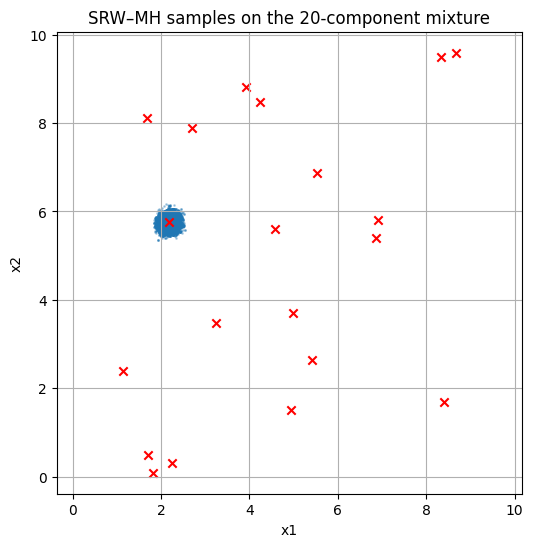

In [197]:
# assign each sample to its nearest mode
dists = np.linalg.norm(samples_post[:, None, :] - mu[None, :, :], axis=-1)
closest = np.argmin(dists, axis=1)
counts = np.bincount(closest, minlength=L)

print("Empirical proportions in each mode:")
print(counts / counts.sum())
print("Theoretical proportions in each mode:")
print(weights)

plt.figure(figsize=(6, 6))
plt.scatter(samples_post[:, 0], samples_post[:, 1], s=1, alpha=0.3)
plt.scatter(mu[:, 0], mu[:, 1], c="red", marker="x")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("SRW–MH samples on the 20-component mixture")
plt.axis("equal")
plt.grid()
plt.show()

The Metropolis Hastings algorithm fails to sample from the mixture of gaussians distribution, as it is not able to leave its starting mode.

**Sampling from $\pi$ using the Adaptative MH algorithm**

In [198]:
np.random.seed(24)

# mixture definition
mu = np.load("20means.npy")              # shape (20, 2)
L, d = mu.shape                          # L is the number of gaussians in the mixture
weights = np.full(L, 1.0 / L)
sigmas = np.full(L, 0.1)

log_pi = lambda z : log_mixture_of_gaussians(z, weights, mu, sigmas)

# run MH
z_init = mu[0] #we initialize at the first mode
n_iter = 50000
proposal_scale = 0.15
proposal_cov = (proposal_scale**2) * np.eye(2)

print(f"Sampling {n_iter} samples using Adaptative MH !")
target_distrib = lambda z : np.exp(log_pi(z))
samples, logp, _ = MHwG_adapt(z_init, target_distrib, n_iter)

burn_in = int(n_iter*0.5)
samples_post = samples[burn_in:]

Sampling 50000 samples using Adaptative MH !


**Visualization of our samples repartitions between the modes for the Adaptative MH sampling**

Empirical proportions in each mode:
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.481
 0.    0.    0.    0.    0.    0.    0.    0.519]
Theoretical proportions in each mode:
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


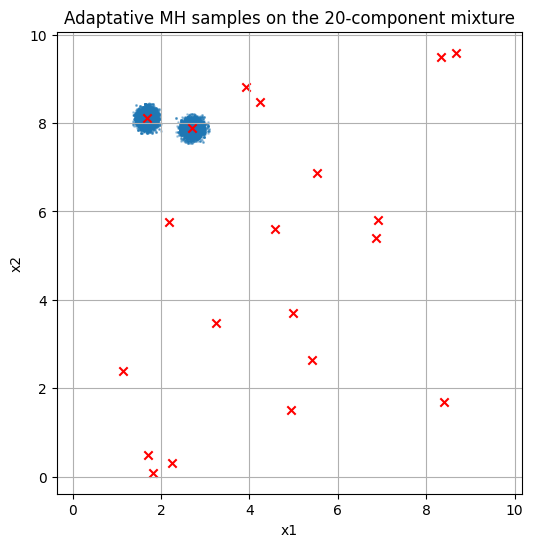

In [199]:
# assign each sample to its nearest mode
dists = np.linalg.norm(samples_post[:, None, :] - mu[None, :, :], axis=-1)
closest = np.argmin(dists, axis=1)
counts = np.bincount(closest, minlength=L)

print("Empirical proportions in each mode:")
print(counts / counts.sum())
print("Theoretical proportions in each mode:")
print(weights)

plt.figure(figsize=(6, 6))
plt.scatter(samples_post[:, 0], samples_post[:, 1], s=1, alpha=0.3)
plt.scatter(mu[:, 0], mu[:, 1], c="red", marker="x")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Adaptative MH samples on the 20-component mixture")
plt.axis("equal")
plt.grid()
plt.show()

Adaptative MH provides a better result as it is able to leave its starting mode, but the result is far from correct.

### **2.B - Parallel Tempering**

#### **Question 1**

It is easier to sample from $\pi_1$ because, for $T_1 > 1$, the tempered target is defined as:

$$\pi^{1/T_1}(x) \propto \exp\left(\frac{1}{T_1}\log\pi(x)\right)$$

This transformation flattens $\pi$: peaks are lower and valleys are higher. This implies that a random-walk Metropolis chain can move more easily between modes and is less likely to get stuck in a single one.

#### **Question 2**

In [200]:
def Parallel_Tempering_algorithm(z_init, log_pi, temperatures, n_iter, proposal_cov_list):
  """
  Computes n_iter iterations of the Parallel Tempering algorithm
  with symmetric random-walk Metropolis–Hastings proposals.

  Inputs

  z_init : initial state of the chains (shape (K, d) or (d,))
  log_pi : function that takes z and returns log pi(z) of the target
  temperatures : list or array of temperatures T_1 > ... > T_K with T_K = 1
  n_iter : number of iterations of the algorithm
  proposal_cov_list : list of Gaussian proposal covariance matrices for each chain

  Returns

  samples : array containing the trajectories of all K chains
  """
  temps = np.asarray(temperatures, dtype=float)
  K = temps.size

  z_init = np.asarray(z_init, dtype=float)
  if z_init.ndim == 1:
    d = z_init.size
    X = np.zeros((n_iter + 1, K, d))
    X[0] = np.tile(z_init, (K, 1))
  else:
    K0, d = z_init.shape
    if K0 != K:
      raise ValueError("z_init must have shape (K, d) or (d,)")
    X = np.zeros((n_iter + 1, K, d))
    X[0] = z_init

  log_pi_vals = np.array([log_pi(X[0, i]) for i in range(K)])

  for it in range(n_iter):
    Y = X[it].copy()
    new_log_pi_vals = log_pi_vals.copy()

    # Sampling part
    for i in range(K):
      z_curr = X[it, i]
      cov_i = proposal_cov_list[i]
      z_prop = np.random.multivariate_normal(mean=z_curr, cov=cov_i)
      log_pi_prop = log_pi(z_prop)
      log_r = (log_pi_prop - log_pi_vals[i]) / temps[i]
      if np.log(np.random.rand()) < log_r:
        Y[i] = z_prop
        new_log_pi_vals[i] = log_pi_prop

    log_pi_vals = new_log_pi_vals

    # Swap part
    idx_i, idx_j = np.random.choice(K, size=2, replace=False)
    iT = temps[idx_i]
    jT = temps[idx_j]

    li = log_pi_vals[idx_i]
    lj = log_pi_vals[idx_j]

    log_swap = (lj / iT + li / jT) - (li / iT + lj / jT)
    if np.log(np.random.rand()) < log_swap:
      tmp = Y[idx_i].copy()
      Y[idx_i] = Y[idx_j]
      Y[idx_j] = tmp
      tmp_lp = log_pi_vals[idx_i]
      log_pi_vals[idx_i] = log_pi_vals[idx_j]
      log_pi_vals[idx_j] = tmp_lp

    X[it + 1] = Y

  return X

#### **Question 3**

In [201]:
np.random.seed(24)

# mixture definition
mu = np.load("20means.npy")              # shape (20, 2)
L, d = mu.shape
weights = np.full(L, 1.0 / L)
sigmas = np.full(L, 0.1)

log_pi = lambda z : log_mixture_of_gaussians(z, weights, mu, sigmas)

# Temperature parameters
K = 5
temperatures = [60.0, 21.6, 7.7, 2.8, 1.0]
tau_list = np.ones(K)

# run MH
z_init = mu[0] #we initialize at the first mode
n_iter = 50000
proposal_cov_list = [(tau**2) * np.eye(d) for tau in tau_list]

print(f"Sampling of {n_iter} samples using Parallel Tempering algorithm ! ")
samples = Parallel_Tempering_algorithm(z_init, log_pi, temperatures, n_iter, proposal_cov_list)

Sampling of 50000 samples using Parallel Tempering algorithm ! 


Empirical proportions in each mode:
[0.05235791 0.03795848 0.05099796 0.05923763 0.03923843 0.03303868
 0.05083797 0.05275789 0.04479821 0.05647774 0.05175793 0.049918
 0.05463781 0.06431743 0.03943842 0.05287788 0.04551818 0.06671733
 0.04983801 0.04727811]


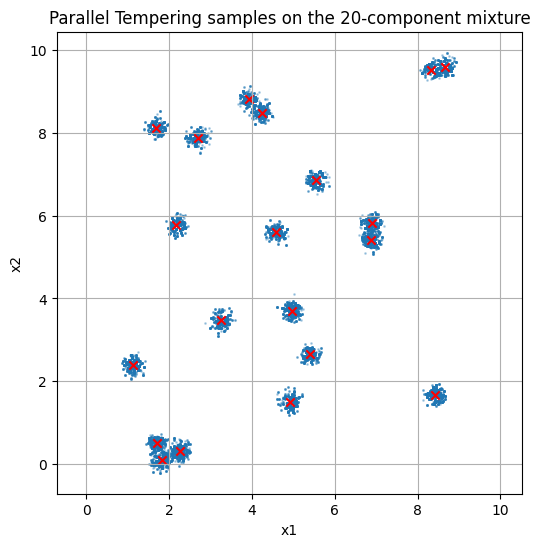

In [202]:
burn_in = int(n_iter*0.5)
samples_post = samples[burn_in:]

# Keep only the coldest chain
samples_cold = samples_post[:, -1, :]

# Assign each sample to its nearest mode
dists = np.linalg.norm(samples_cold[:, None, :] - mu[None, :, :], axis=-1)
closest = np.argmin(dists, axis=1)
counts = np.bincount(closest, minlength=L)
print("Empirical proportions in each mode:")
print(counts / counts.sum())

plt.figure(figsize=(6, 6))
plt.scatter(samples_cold[:, 0], samples_cold[:, 1], s=1, alpha=0.3)
plt.scatter(mu[:, 0], mu[:, 1], c="red", marker="x")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Parallel Tempering samples on the 20-component mixture")
plt.axis("equal")
plt.grid()
plt.show()

We now try with $\tau_i = 0.25\sqrt{T_i}$

In [203]:
np.random.seed(24)

# mixture definition
mu = np.load("20means.npy")              # shape (20, 2)
L, d = mu.shape
weights = np.full(L, 1.0 / L)
sigmas = np.full(L, 0.1)

log_pi = lambda z : log_mixture_of_gaussians(z, weights, mu, sigmas)

# Temperature parameters
K = 5
temperatures = [60.0, 21.6, 7.7, 2.8, 1.0]
tau_list =  0.25 * np.sqrt(temperatures)

# run MH
z_init = mu[0] #we initialize at the first mode
n_iter = 50000
proposal_cov_list = [(tau**2) * np.eye(d) for tau in tau_list]

print(f"Sampling of {n_iter} samples using Parallel Tempering algorithm ! ")
samples = Parallel_Tempering_algorithm(z_init, log_pi, temperatures, n_iter, proposal_cov_list)

Sampling of 50000 samples using Parallel Tempering algorithm ! 


Empirical proportions in each mode:
[0.03891844 0.04955802 0.04207832 0.0475981  0.04779809 0.05779769
 0.04775809 0.06599736 0.04907804 0.05475781 0.04567817 0.04083837
 0.06551738 0.04843806 0.05387784 0.06211752 0.04107836 0.03227871
 0.06783729 0.04099836]


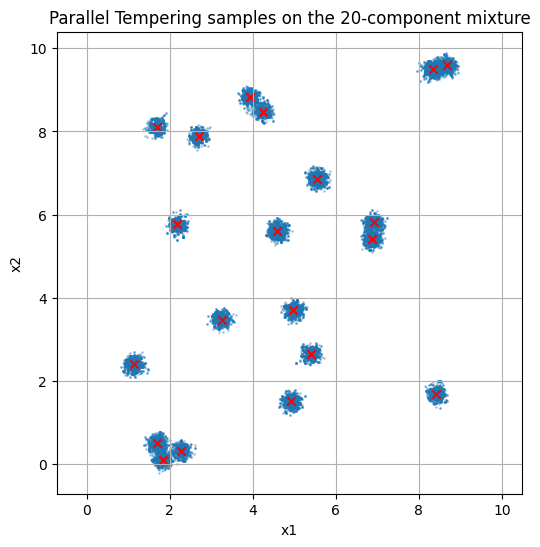

In [204]:
burn_in = int(n_iter*0.5)
samples_post = samples[burn_in:]

# Keep only the coldest chain
samples_cold = samples_post[:, -1, :]

# Assign each sample to its nearest mode
dists = np.linalg.norm(samples_cold[:, None, :] - mu[None, :, :], axis=-1)
closest = np.argmin(dists, axis=1)
counts = np.bincount(closest, minlength=L)
print("Empirical proportions in each mode:")
print(counts / counts.sum())

plt.figure(figsize=(6, 6))
plt.scatter(samples_cold[:, 0], samples_cold[:, 1], s=1, alpha=0.3)
plt.scatter(mu[:, 0], mu[:, 1], c="red", marker="x")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Parallel Tempering samples on the 20-component mixture")
plt.axis("equal")
plt.grid()
plt.show()

## **Exercise 3: Bayesian analysis of a one-way random effects model (Bonus - 3pt)**


### **Question 1**


Introducing $\theta = (\mu, \sigma^2, \tau^2)$ and using Bayes' formula, we get:

$$
\pi(x, \theta \mid y) \propto \pi(y \mid x, \theta) \, \pi(x \mid \theta) \, \pi(\theta).
$$

From the model, $Y_{i,j} \mid X_i, \theta \sim \mathcal{N}(X_i, \tau^2)$ so:

$$
\pi(y \mid x, \theta) \propto (\tau^2)^{-k/2} \exp\left( -\frac{1}{2\tau^2} \sum_{i=1}^N \sum_{j=1}^{k_i} (y_{i,j} - x_i)^2 \right).
$$

The random effects satisfy $X_i \mid \theta \sim \mathcal{N}(\mu, \sigma^2)$ i.i.d., hence:

$$
\pi(x \mid \theta) \propto (\sigma^2)^{-N/2} \exp\left( -\frac{1}{2\sigma^2} \sum_{i=1}^N (x_i - \mu)^2 \right).
$$

Finally, the prior on $\theta$ is:

$$
\pi(\theta) = \pi_{\text{prior}}(\mu, \sigma^2, \tau^2) \propto (\sigma^2)^{-(1+\alpha)}\exp\left(-\frac{\beta}{\sigma^2}\right) (\tau^2)^{-(1+\gamma)}\exp\left(-\frac{\beta}{\tau^2}\right).
$$

Multiplying these terms gives the posterior density (up to a constant):

$$
\begin{aligned}
\pi(x, \mu, \sigma^2, \tau^2 \mid y) \propto \quad & (\sigma^2)^{-\left(\frac{N}{2} + 1 + \alpha\right)} (\tau^2)^{-\left(\frac{k}{2} + 1 + \gamma\right)} \\
& \times \exp\left\{ -\frac{1}{2\tau^2}\sum_{i=1}^N\sum_{j=1}^{k_i}(y_{i,j}-x_i)^2 -\frac{1}{2\sigma^2}\sum_{i=1}^N(x_i-\mu)^2 -\frac{\beta}{\sigma^2} -\frac{\beta}{\tau^2} \right\}.
\end{aligned}
$$

### **Question 2**

In [205]:
def gibbs_random_effects(Y, n_iter, alpha, beta, gamma,
                         mu_init=0.0, sigma_sq_init=1.0, tau_sq_init=1.0):
  """
  Computes n_iter iterations of a Gibbs sampler for the one-way random effects model.

  Inputs

  Y : list where Y[i] contains the observations {y_{i,1}, ..., y_{i,k_i}}
  n_iter : number of Gibbs iterations
  alpha, beta, gamma : hyperparameters of the priors
  mu_init : initial value of mu
  sigma_sq_init : initial value of sigma^2
  tau_sq_init : initial value of tau^2

  Returns

  mu_chain : array containing the sampled values of mu
  sigma_sq_chain : array containing the sampled values of sigma^2
  tau_sq_chain : array containing the sampled values of tau^2
  X_chain : array containing the sampled values of the random effects X_i
  """
  Y_list = [np.asarray(y_i) for y_i in Y]
  N = len(Y_list)
  k_i = np.array([len(y_i) for y_i in Y_list])
  k_tot = k_i.sum()

  mu = mu_init
  sigma_sq = sigma_sq_init
  tau_sq = tau_sq_init
  X = np.array([y_i.mean() for y_i in Y_list])

  mu_chain = np.zeros(n_iter)
  sigma_sq_chain = np.zeros(n_iter)
  tau_sq_chain = np.zeros(n_iter)
  X_chain = np.zeros((n_iter, N))

  # We use a SRW proposal for each component
  for t in range(n_iter):
    # sigma^2 | mu, X, Y, tau^2
    a_sigma = alpha + N / 2.0
    b_sigma = beta + 0.5 * np.sum((X - mu)**2)
    sigma_sq = invgamma.rvs(a=a_sigma, scale=b_sigma)

    # tau^2 | mu, X, Y, sigma^2
    res2 = 0.0
    for i in range(N):
      res2 += np.sum((Y_list[i] - X[i])**2)
    a_tau = gamma + k_tot / 2.0
    b_tau = beta + 0.5 * res2
    tau2 = invgamma.rvs(a=a_tau, scale=b_tau)

    # mu | X, sigma^2, tau^2, Y
    mu_var = sigma_sq / N
    mu_mean = X.mean()
    mu = np.random.normal(mu_mean, np.sqrt(mu_var))

    # X_i | mu, sigma^2, tau^2, Y
    for i in range(N):
      sum_y_i = Y_list[i].sum()
      prec_prior = 1.0 / sigma_sq
      prec_like = k_i[i] / tau2
      var_i = 1.0 / (prec_prior + prec_like)
      mean_i = var_i * (mu / sigma_sq + sum_y_i / tau2)
      X[i] = np.random.normal(mean_i, np.sqrt(var_i))

    mu_chain[t] = mu
    sigma_sq_chain[t] = sigma_sq
    tau_sq_chain[t] = tau2
    X_chain[t] = X

  return mu_chain, sigma_sq_chain, tau_sq_chain, X_chain


### **Question 3**

In [206]:
def simulate_random_effects(N, k_i, mu_true, sigma_sq_true, tau_sq_true):
  """
  Simulates data from the one-way random effects model.

  Inputs

  N : number of groups
  k_i : list or array giving the number of observations in each group
  mu_true : true value of mu
  sigma2_true : true value of sigma^2
  tau2_true : true value of tau^2
  seed : random seed (optional)

  Returns

  Y : list where Y[i] contains the simulated observations for group i
  X_true : array containing the true random effects X_i
  """
  k_i = np.asarray(k_i)
  X_true = np.random.normal(mu_true, np.sqrt(sigma_sq_true), size=N)

  Y = []
  for i in range(N):
    eps_i = np.random.normal(0.0, np.sqrt(tau_sq_true), size=k_i[i])
    Y_i = X_true[i] + eps_i
    Y.append(Y_i)

  return Y, X_true


In [208]:
np.random.seed(24)

# true parameters
mu_true = 2.0
sigma_sq_true = 1.0
tau_sq_true = 0.5

N = 10
k_i = np.full(N, 5)

Y, X_true = simulate_random_effects(N, k_i, mu_true, sigma_sq_true, tau_sq_true)

alpha = 2.0
beta = 2.0
gamma = 2.0
n_iter = 5000

mu_chain, sigma_sq_chain, tau_sq_chain, X_chain = gibbs_random_effects(Y, n_iter, alpha, beta, gamma,mu_init=0.0,
                                                                       sigma_sq_init=1.0, tau_sq_init=1.0)

burn_in = n_iter // 2
print("Posterior mean of mu:", mu_chain[burn_in:].mean(), " (true:", mu_true, ")")
print("Posterior mean of sigma^2:", sigma_sq_chain[burn_in:].mean(), " (true:", sigma_sq_true, ")")
print("Posterior mean of tau^2:", tau_sq_chain[burn_in:].mean(), " (true:", tau_sq_true, ")")

Posterior mean of mu: 1.832019291869439  (true: 2.0 )
Posterior mean of sigma^2: 1.083309908431718  (true: 1.0 )
Posterior mean of tau^2: 0.5010596396475957  (true: 0.5 )
